In [80]:
workflow = {
    1: "Data Preparation and Loading",
    2: "Building Model",
    3: "Train: fitting the model to the data",
    4: "Infere: test (predict and evaluate) the trained model on unseed data",
    5: "Saving and loading a model",
    6: "Putting it all together"
}

In [81]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [82]:
torch.__version__

'2.4.1+cu121'

# Create Dataset

In [83]:
# Create known parameters

w = 0.7
b = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = w * X + b

In [84]:
X[:10], y[:10], X.shape, y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

In [85]:
# split data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

# Plot Data

In [86]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions= None):

    """
    Plots train data, test data and compares predictions.
    """

    plt.figure(figsize=(10, 7))

    # Plot train data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Train Data")
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")

    if predictions is not None:
        # Plot predictions in red based on test data
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show Legend
    plt.legend(prop={"size": 14});

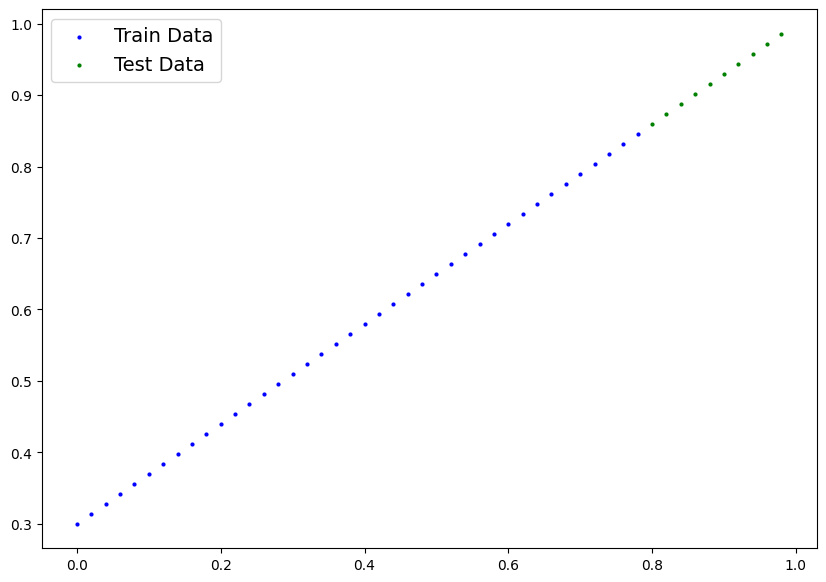

In [87]:
plot_predictions();

# Build Model

In [88]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(torch.randn(1, dtype = torch.float),
                                    requires_grad = True)

        self.bias = nn.Parameter(torch.randn(1, dtype = torch.float),
                                 requires_grad = True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias



In [89]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

print(list(model_0.parameters()))
print(f"\n{model_0.state_dict()}")

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


In [90]:
# Test inference
with torch.inference_mode():
    y_preds = model_0(X_test)

In [91]:
len(X_test), len(y_preds), y_preds

(10,
 10,
 tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]))

tensor([[-0.4618],
        [-0.4691],
        [-0.4764],
        [-0.4836],
        [-0.4909],
        [-0.4982],
        [-0.5054],
        [-0.5127],
        [-0.5200],
        [-0.5272]])

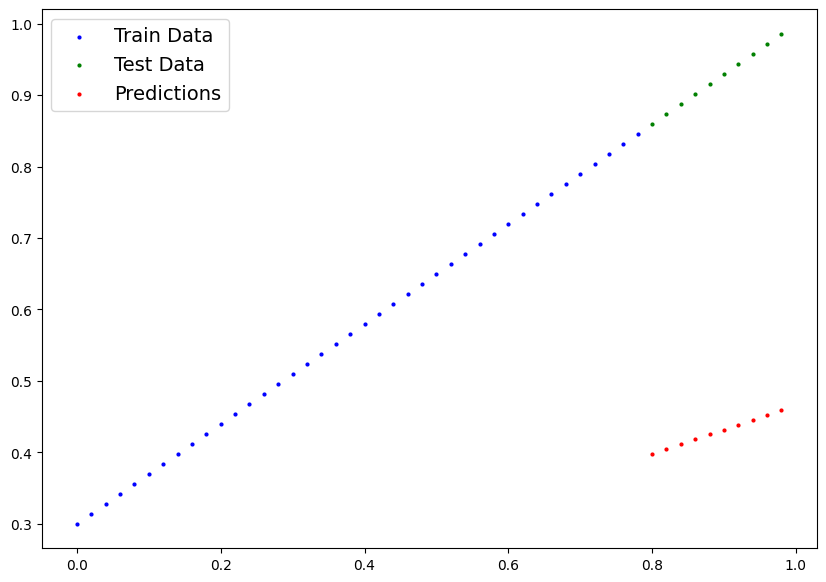

In [92]:
plot_predictions(predictions = y_preds);
y_preds - y_test

# Train Model

In [93]:
# Hyperprameters

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)
epochs = 100

# lists to track loss prgress

epoch_count = []
train_loss_values = []
test_loss_values = []

torch.manual_seed(42)

for epoch in range(epochs):

    ### Train ###

    model_0.train()

    y_train_pred = model_0(X_train)

    train_loss = loss_fn(y_train_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    ### Test ###

    model_0.eval()

    with torch.inference_mode():
        y_test_pred = model_0(X_test)

    test_loss = loss_fn(y_test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | MAE Train Loss: {train_loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


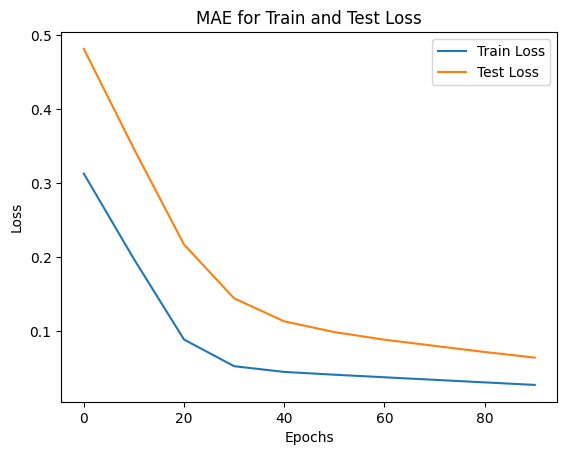

In [94]:
plt.plot(epoch_count, train_loss_values, label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.title("MAE for Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [95]:
print("The values the model learned from training:")
print(f"Old hard-coded values: weights = {w}, bias = {b}")
print(f'New values: {model_0.state_dict()}')

The values the model learned from training:
Old hard-coded values: weights = 0.7, bias = 0.3
New values: OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])


# Inference

In [96]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [97]:
y_preds.shape

torch.Size([10, 1])

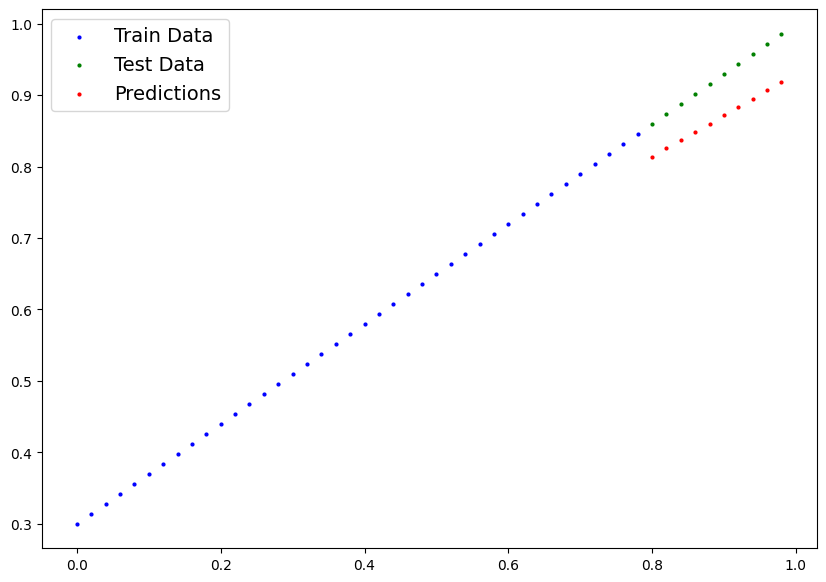

In [98]:
plot_predictions(predictions= y_preds);

# Save and load the model

In [99]:
from pathlib import Path

In [100]:
# create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "linear_regression_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict (only model parameters are saved)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/linear_regression_model.pth


In [101]:
# check the saved model path
!ls -l models/linear_regression_model.pth

-rw-r--r-- 1 root root 1656 Oct  6 11:55 models/linear_regression_model.pth


In [102]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH, weights_only = True))

<All keys matched successfully>

In [103]:
# Test inference with the loaded model

loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [104]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together (repeating what is done so far)

In [105]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [106]:
torch.__version__

'2.4.1+cu121'

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Used device: {device}")

Used device: cpu


### create data

In [108]:
w = 0.9
b = 0.2

start = 0
end = 1
step = 0.015

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = w * X + b

print(X[:10])
print(y[:10])

tensor([[0.0000],
        [0.0150],
        [0.0300],
        [0.0450],
        [0.0600],
        [0.0750],
        [0.0900],
        [0.1050],
        [0.1200],
        [0.1350]])
tensor([[0.2000],
        [0.2135],
        [0.2270],
        [0.2405],
        [0.2540],
        [0.2675],
        [0.2810],
        [0.2945],
        [0.3080],
        [0.3215]])


### Split data

In [109]:
print(len(X))

train_split = int(0.75 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

67
50 50 17 17


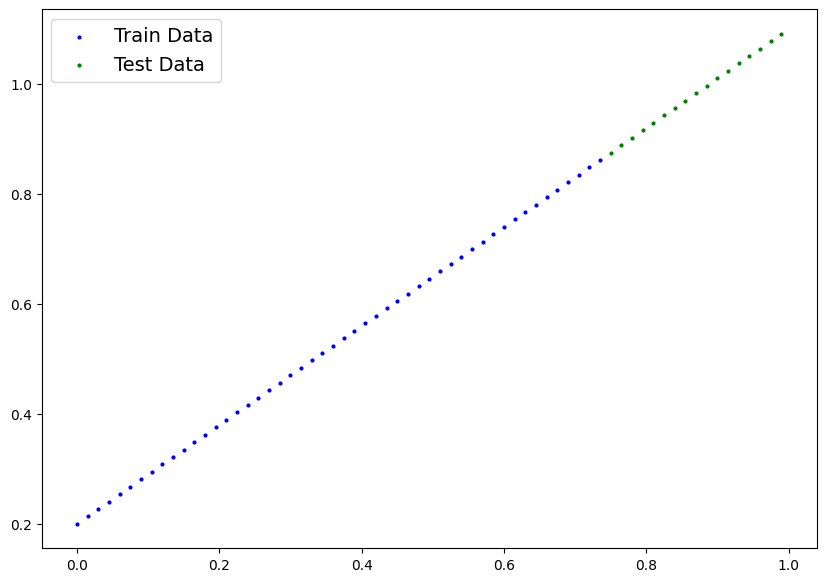

In [110]:
plot_predictions(X_train, y_train, X_test, y_test);

### Building a linear model V2

In [111]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features = 1, out_features = 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [112]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [113]:
next(model_1.parameters()).device

device(type='cpu')

In [114]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

### Train the model

In [115]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [116]:
torch.manual_seed(42)

for epoch in range(epochs):

    ### Train mode ###
    model_1.train()


    train_pred = model_1(X_train) # forward


    train_loss = loss_fn(train_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    ### Eval mode ###

    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5802258253097534 | Test Loss: 0.4989592134952545
Epoch: 100 | Train Loss: 0.04403387010097504 | Test Loss: 0.11137492954730988
Epoch: 200 | Train Loss: 0.013321428559720516 | Test Loss: 0.03290890157222748
Epoch: 300 | Train Loss: 0.002779747825115919 | Test Loss: 0.012642727233469486
Epoch: 400 | Train Loss: 0.002779747825115919 | Test Loss: 0.012642727233469486
Epoch: 500 | Train Loss: 0.002779747825115919 | Test Loss: 0.012642727233469486
Epoch: 600 | Train Loss: 0.002779747825115919 | Test Loss: 0.012642727233469486
Epoch: 700 | Train Loss: 0.002779747825115919 | Test Loss: 0.012642727233469486
Epoch: 800 | Train Loss: 0.002779747825115919 | Test Loss: 0.012642727233469486
Epoch: 900 | Train Loss: 0.002779747825115919 | Test Loss: 0.012642727233469486


In [117]:
from pprint import pprint

In [118]:
print("Learned Parameters:")
pprint(model_1.state_dict())
print(f"The original parameters: weight = {w}; bias = {b}")

Learned Parameters:
OrderedDict([('linear_layer.weight', tensor([[0.8956]])),
             ('linear_layer.bias', tensor([0.2044]))])
The original parameters: weight = 0.9; bias = 0.2


### Inference

In [119]:
model_1.eval()

with torch.inference_mode():
    infer_preds = model_1(X_test)

infer_preds

tensor([[0.8761],
        [0.8895],
        [0.9030],
        [0.9164],
        [0.9298],
        [0.9433],
        [0.9567],
        [0.9701],
        [0.9836],
        [0.9970],
        [1.0104],
        [1.0239],
        [1.0373],
        [1.0507],
        [1.0642],
        [1.0776],
        [1.0910]])

In [120]:
X_test.shape, infer_preds.shape

(torch.Size([17, 1]), torch.Size([17, 1]))

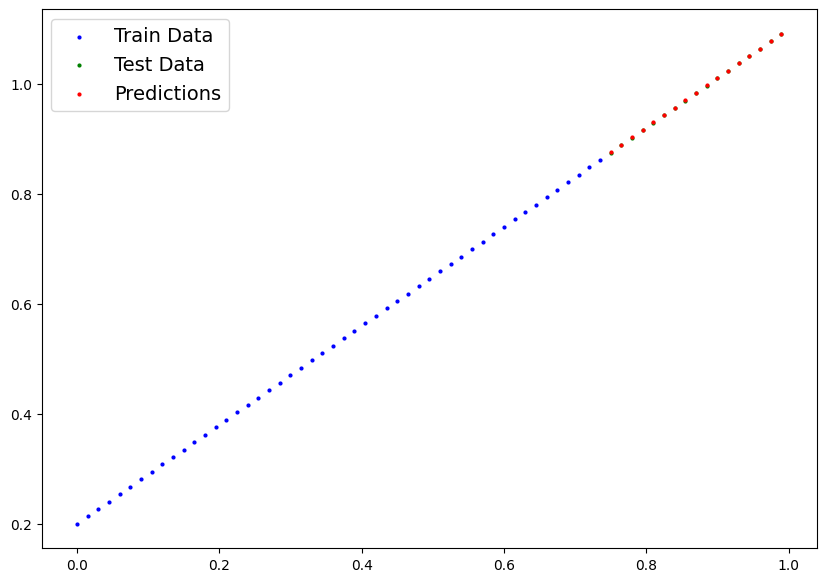

In [121]:
plot_predictions(X_train, y_train, X_test, y_test, predictions = infer_preds.cpu());

### Saving and loading the model

In [122]:
from pathlib import Path

In [123]:
# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Create model save path
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving the model to: models/model_1.pth


In [124]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only = True))

loaded_model_1.to(device)

print(f"Loaded Model:\n{loaded_model_1}")
print(f"Model on device: {next(loaded_model_1.parameters()).device}")

Loaded Model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device: cpu


In [125]:
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test)

infer_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Exercises

In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Model 2

In [127]:
w = 0.3
b = 0.9

X = torch.arange(0, 1, 0.01, dtype = torch.float).unsqueeze(dim = 1)
y = w * X + b

In [128]:
len(X), len(y)

(100, 100)

In [129]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [130]:
len(X_train), len(X_test), len(y_train), len(y_test)

(80, 20, 80, 20)

In [131]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions = None):
    plt.figure(figsize = (10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Train Data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop = {"size": 14})

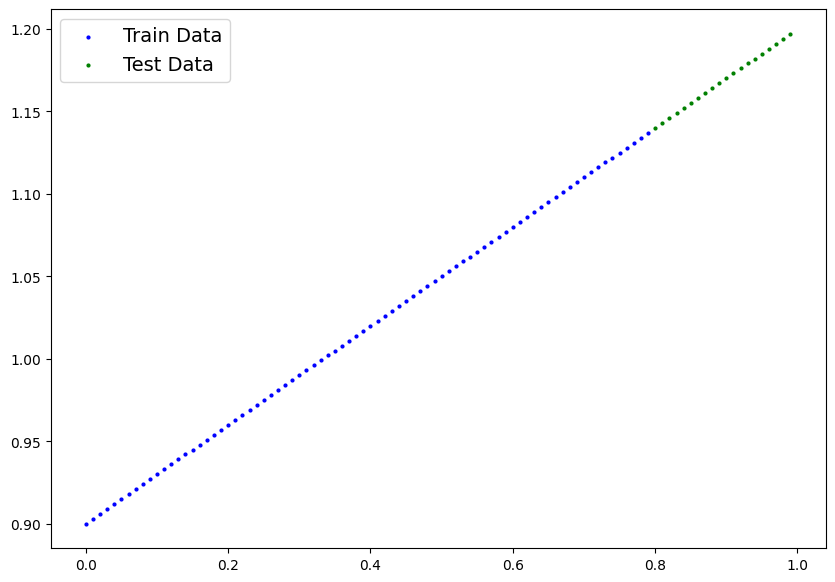

In [132]:
plot_predictions(train_data = X_train, test_data = X_test, train_labels = y_train, test_labels = y_test);

In [133]:
class LinearRegressionModelV3(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear_layer = nn.Linear(in_features = 1, out_features = 1, dtype = torch.float)

    def forward(self, X: torch.Tensor) -> torch.Tensor:

        return self.linear_layer(X)

In [134]:
model_2 = LinearRegressionModelV3()

model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2343]])),
             ('linear_layer.bias', tensor([0.9186]))])

In [135]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)

epochs = 300

torch.manual_seed(42)

In [136]:
for epoch in range(epochs):

    ### Train ###
    model_2.train()

    train_pred = model_2(X_train)

    train_loss = loss_fn(train_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    ### Eval ###
    model_2.eval()

    with torch.inference_mode():
        test_pred = model_2(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.1934860348701477 | Test Loss: 0.44704073667526245
Epoch: 20 | Train Loss: 0.099742591381073 | Test Loss: 0.2774539589881897
Epoch: 40 | Train Loss: 0.08286076784133911 | Test Loss: 0.20952367782592773
Epoch: 60 | Train Loss: 0.07524622231721878 | Test Loss: 0.17951278388500214
Epoch: 80 | Train Loss: 0.06834527105093002 | Test Loss: 0.16077637672424316
Epoch: 100 | Train Loss: 0.06149417161941528 | Test Loss: 0.1444476842880249
Epoch: 120 | Train Loss: 0.05464210361242294 | Test Loss: 0.12846292555332184
Epoch: 140 | Train Loss: 0.0477910041809082 | Test Loss: 0.11213425546884537
Epoch: 160 | Train Loss: 0.040939826518297195 | Test Loss: 0.09580682963132858
Epoch: 180 | Train Loss: 0.03408767282962799 | Test Loss: 0.07982330024242401
Epoch: 200 | Train Loss: 0.027236470952630043 | Test Loss: 0.06349574029445648
Epoch: 220 | Train Loss: 0.020384784787893295 | Test Loss: 0.04734015464782715
Epoch: 240 | Train Loss: 0.013533586636185646 | Test Loss: 0.031012600287

### Model 3

In [137]:
w = 0.3
b = 0.9

X = torch.arange(20, 520, 5, dtype = torch.float).unsqueeze(dim = 1)
y = w * X + b

In [138]:
len(X), len(y)

(100, 100)

In [139]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [140]:
len(X_train), len(X_test), len(y_train), len(y_test)

(80, 20, 80, 20)

In [141]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions = None):
    plt.figure(figsize = (10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Train Data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop = {"size": 14})

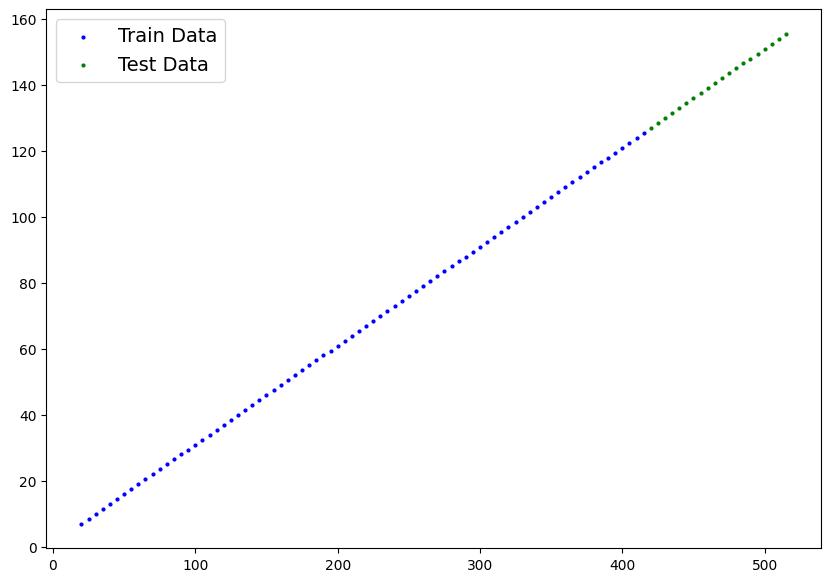

In [142]:
plot_predictions(train_data = X_train, test_data = X_test, train_labels = y_train, test_labels = y_test);

In [143]:
class LinearRegressionModelV4(nn.Module):

    def __init__(self):
        super().__init__()

        self.w = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)
        self.b = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:

        return self.w * X + self.b

In [144]:
model_3 = LinearRegressionModelV4()

model_3.state_dict()

OrderedDict([('w', tensor([0.3367])), ('b', tensor([0.1288]))])

In [145]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.0000001)

epochs = 300

torch.manual_seed(42)

In [146]:
for epoch in range(epochs):

    ### Train ###
    model_3.train()

    train_pred = model_3(X_train)

    train_loss = loss_fn(train_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    ### Eval ###
    model_3.eval()

    with torch.inference_mode():
        test_pred = model_3(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 7.209895133972168 | Test Loss: 16.371421813964844
Epoch: 20 | Train Loss: 7.115732669830322 | Test Loss: 16.168563842773438
Epoch: 40 | Train Loss: 7.021569728851318 | Test Loss: 15.965688705444336
Epoch: 60 | Train Loss: 6.927403926849365 | Test Loss: 15.762832641601562
Epoch: 80 | Train Loss: 6.8332414627075195 | Test Loss: 15.559972763061523
Epoch: 100 | Train Loss: 6.73907995223999 | Test Loss: 15.357114791870117
Epoch: 120 | Train Loss: 6.644917964935303 | Test Loss: 15.154255867004395
Epoch: 140 | Train Loss: 6.550753116607666 | Test Loss: 14.951398849487305
Epoch: 160 | Train Loss: 6.4565911293029785 | Test Loss: 14.748540878295898
Epoch: 180 | Train Loss: 6.362427711486816 | Test Loss: 14.545666694641113
Epoch: 200 | Train Loss: 6.268265724182129 | Test Loss: 14.342806816101074
Epoch: 220 | Train Loss: 6.174100399017334 | Test Loss: 14.139948844909668
Epoch: 240 | Train Loss: 6.079937934875488 | Test Loss: 13.937090873718262
Epoch: 260 | Train Loss: 5.985

In [147]:
model_2.eval()

with torch.inference_mode():
    inference = model_2(X_test)

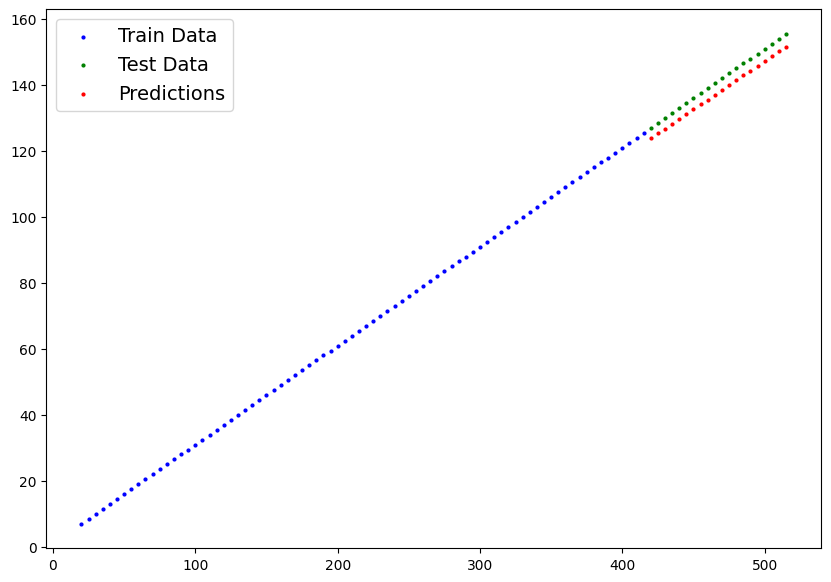

In [152]:
plot_predictions(X_train, y_train, X_test, y_test, inference);

In [149]:
X_test.shape, inference.shape

(torch.Size([20, 1]), torch.Size([20, 1]))

In [153]:
from pathlib import Path

In [155]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = "model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(), f = MODEL_SAVE_PATH)

Saving the model to: models/model_2.pth


In [158]:
loaded_model_2 = LinearRegressionModelV3()

loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH, weights_only = True))

<All keys matched successfully>

In [159]:
loaded_model_2.eval()

with torch.inference_mode():
    loaded_infer = loaded_model_2(X_test)

loaded_infer == inference

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Stop
